## Введение
У нас имеется датасет, содержащий данные, предоставленные компанией **VISA**, на официальном сайте. 

## Наша задача
В этой работе мы хотим:<br>
1. изучить данные,
2. выбрать алгоритм,
3. обучить и проверить метрики на выходе.


## Описание данных 
И так, у нас имеется датасет, который содержит следующие поля:<br> 
1. `target` - целевой признак, тот который надо предсказать и который по своему существу является ничем иным как полом каждого пользователя карты **VISA**;
2. `client_id` -уник. номер клиента (держателя карты);
3. `dt_range` - ничто иное, как дата операции, в формате **дни с даты активации** - **ч-м-с**;
4. `sum` - сумма транзакции, которая была проведена пользователем;
5. `event_name` - код наименования транзакции;
6. `transaction_purpose` - цель транзакции.


## Библиотеки
Здесь выгрузим необходимые библиотеки.

In [271]:
# 01001101 01100001 01111001 00100000 01110100 01101000 01100101
# 00100000 01000110 01101111 01110010 01100011 01100101 00100000
# 01100010 01100101 00100000 01110111 01101001 01110100 01101000 
# 00100000 01111001 01101111 01110101 00100001

import matplotlib.pyplot as plt
import textwrap
import numpy as np
import plotly.express as px
import seaborn as sns
from statistics import *
import re
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
from matplotlib.colors import ListedColormap
import datetime as dt
from plotly import graph_objects as go
from scipy import stats as st
import math as mt
import sklearn

# pydot
import pydot
import graphviz

## Accuracy/Precision/Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score

# для OHE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## 
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

## Датасет и общая информация о данных
Выгрузим данные и узнаем их получше.

In [234]:
transactions = pd.read_csv("visa_customers.csv")
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91826 entries, 0 to 91825
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           91826 non-null  int64  
 1   RangeIndex           91826 non-null  int64  
 2   client_id            91826 non-null  int64  
 3   dt_range             91826 non-null  object 
 4   sum                  91826 non-null  float64
 5   target               91826 non-null  int64  
 6   event_name           91826 non-null  object 
 7   transaction_purpose  91826 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 5.6+ MB


In [235]:
transactions.head(3)

,Unnamed: 0,RangeIndex,client_id,dt_range,sum,target,event_name,transaction_purpose
0,0,0,880096372458,421 06:33:15,-561478.94,0,d7a84628c025d30f7b2c52c958767e76,e3b80d30a727c738f3cff0941f6bc55a
1,1,1,880096372458,270 06:16:18,224591.58,0,281715cafa675bf359ebaa42cb44fa17,e3b80d30a727c738f3cff0941f6bc55a
2,2,2,880096372458,97 10:48:35,-11229.58,0,ca43108ded5aabc7793d3f9b928cdd54,926ec030f29f83ce5318754fdb631a33


**Вывод:**
1. Лишние поля **Unnamed** и **RangeIndex** должны быть сброшены (удалены);
2. Не все из поля **dt_range** нам нужно, видимо, придется сбросить лишние части и проработать далее.

## Предобработка данных
И так, предобработка имеющихся признаков, но вначале избавимся от ненужных признаков.
### Удаление лишних признаков

In [236]:
transactions = transactions.drop(["Unnamed: 0", "RangeIndex"], axis = 1)

In [237]:
transactions.head()

,client_id,dt_range,sum,target,event_name,transaction_purpose
0,880096372458,421 06:33:15,-561478.94,0,d7a84628c025d30f7b2c52c958767e76,e3b80d30a727c738f3cff0941f6bc55a
1,880096372458,270 06:16:18,224591.58,0,281715cafa675bf359ebaa42cb44fa17,e3b80d30a727c738f3cff0941f6bc55a
2,880096372458,97 10:48:35,-11229.58,0,ca43108ded5aabc7793d3f9b928cdd54,926ec030f29f83ce5318754fdb631a33
3,880096372458,445 07:33:38,-417695.42,0,619205da514e83f869515c782a328d3c,926ec030f29f83ce5318754fdb631a33
4,880096372458,4 09:33:46,-2245.92,0,e515df0d202ae52fcebb14295743063b,084afd913ab1e6ea58b8ca73f6cb41a6


### Feature Engineering
#### Признак **dt_range**
##### Час-минута-секунда
У нас имеется признак **dt_range**, который, как нам известно, преобразован в мета-данные пользовательской активности. Нам же, в свою очередь достаточно выяснить, имелись ли какие либо аномалий в течение периода времени, и если ответ - нет, то мы можем оставить из всего поля только следующее:
1) Количество дней;
2) Номер месяца активности;
3) Час;
4) Минуту;
5) Секунду.

In [238]:
transactions.loc[:, "num_days"] =  transactions.loc[:, "dt_range"].str.split(" ", expand=True)[0]
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91826 entries, 0 to 91825
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            91826 non-null  int64  
 1   dt_range             91826 non-null  object 
 2   sum                  91826 non-null  float64
 3   target               91826 non-null  int64  
 4   event_name           91826 non-null  object 
 5   transaction_purpose  91826 non-null  object 
 6   num_days             91826 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 4.9+ MB


In [239]:
transactions.loc[:, "num_days"] = transactions.loc[:, "num_days"].astype("int")
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91826 entries, 0 to 91825
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            91826 non-null  int64  
 1   dt_range             91826 non-null  object 
 2   sum                  91826 non-null  float64
 3   target               91826 non-null  int64  
 4   event_name           91826 non-null  object 
 5   transaction_purpose  91826 non-null  object 
 6   num_days             91826 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 4.6+ MB


In [240]:
transactions.loc[:, "hour"] =  transactions.loc[:, "dt_range"].str.split(" |:", expand=True)[1]
transactions.loc[:, "minute"] =  transactions.loc[:, "dt_range"].str.split(":", expand=True)[1]
transactions.loc[:, "sec"] =  transactions.loc[:, "dt_range"].str.split(":", expand=True)[2]
transactions=transactions.drop("dt_range", axis=1)
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91826 entries, 0 to 91825
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            91826 non-null  int64  
 1   sum                  91826 non-null  float64
 2   target               91826 non-null  int64  
 3   event_name           91826 non-null  object 
 4   transaction_purpose  91826 non-null  object 
 5   num_days             91826 non-null  int32  
 6   hour                 91826 non-null  object 
 7   minute               91826 non-null  object 
 8   sec                  91826 non-null  object 
dtypes: float64(1), int32(1), int64(2), object(5)
memory usage: 6.0+ MB


In [241]:
transactions.loc[:, "hour"] = transactions.loc[:, "hour"].astype("int")
transactions.loc[:, "minute"] = transactions.loc[:, "minute"].astype("int")
transactions.loc[:, "sec"] = transactions.loc[:, "sec"].astype("int")
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91826 entries, 0 to 91825
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            91826 non-null  int64  
 1   sum                  91826 non-null  float64
 2   target               91826 non-null  int64  
 3   event_name           91826 non-null  object 
 4   transaction_purpose  91826 non-null  object 
 5   num_days             91826 non-null  int32  
 6   hour                 91826 non-null  int32  
 7   minute               91826 non-null  int32  
 8   sec                  91826 non-null  int32  
dtypes: float64(1), int32(4), int64(2), object(2)
memory usage: 4.9+ MB


In [242]:
transactions.head(3)

,client_id,sum,target,event_name,transaction_purpose,num_days,hour,minute,sec
0,880096372458,-561478.94,0,d7a84628c025d30f7b2c52c958767e76,e3b80d30a727c738f3cff0941f6bc55a,421,6,33,15
1,880096372458,224591.58,0,281715cafa675bf359ebaa42cb44fa17,e3b80d30a727c738f3cff0941f6bc55a,270,6,16,18
2,880096372458,-11229.58,0,ca43108ded5aabc7793d3f9b928cdd54,926ec030f29f83ce5318754fdb631a33,97,10,48,35


Теперь мы снизим порядок признака **hour** до состояния бинарного. То есть, ***AM:PM*** таким образом, наши данные не будут такими сложными. 
Словарь:
1. AM = 0;
2. PM = 1.

In [243]:
def daytime_definer(dt):
    if dt >= 12:
        return 1
    else:
        return 0

In [244]:
transactions.loc[:, "day_time"] = transactions.loc[:, "hour"].apply(daytime_definer)
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91826 entries, 0 to 91825
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            91826 non-null  int64  
 1   sum                  91826 non-null  float64
 2   target               91826 non-null  int64  
 3   event_name           91826 non-null  object 
 4   transaction_purpose  91826 non-null  object 
 5   num_days             91826 non-null  int32  
 6   hour                 91826 non-null  int32  
 7   minute               91826 non-null  int32  
 8   sec                  91826 non-null  int32  
 9   day_time             91826 non-null  int64  
dtypes: float64(1), int32(4), int64(3), object(2)
memory usage: 5.6+ MB


In [245]:
transactions = transactions.drop(["minute", "sec"], axis = 1)
transactions.head(3)

,client_id,sum,target,event_name,transaction_purpose,num_days,hour,day_time
0,880096372458,-561478.94,0,d7a84628c025d30f7b2c52c958767e76,e3b80d30a727c738f3cff0941f6bc55a,421,6,0
1,880096372458,224591.58,0,281715cafa675bf359ebaa42cb44fa17,e3b80d30a727c738f3cff0941f6bc55a,270,6,0
2,880096372458,-11229.58,0,ca43108ded5aabc7793d3f9b928cdd54,926ec030f29f83ce5318754fdb631a33,97,10,0


##### Признак **month**
Как мы обговорили ранее, нам сейчас необходимо преобразовать данные о времени активности таким образом, чтобы получить отдельный признак **month**, тобишь - месяц.

In [246]:
transactions.loc[:, "month"] = np.ceil(transactions.loc[:, "num_days"]/30)
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91826 entries, 0 to 91825
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            91826 non-null  int64  
 1   sum                  91826 non-null  float64
 2   target               91826 non-null  int64  
 3   event_name           91826 non-null  object 
 4   transaction_purpose  91826 non-null  object 
 5   num_days             91826 non-null  int32  
 6   hour                 91826 non-null  int32  
 7   day_time             91826 non-null  int64  
 8   month                91826 non-null  float64
dtypes: float64(2), int32(2), int64(3), object(2)
memory usage: 5.6+ MB


In [247]:
transactions.head(5)

,client_id,sum,target,event_name,transaction_purpose,num_days,hour,day_time,month
0,880096372458,-561478.94,0,d7a84628c025d30f7b2c52c958767e76,e3b80d30a727c738f3cff0941f6bc55a,421,6,0,15.0
1,880096372458,224591.58,0,281715cafa675bf359ebaa42cb44fa17,e3b80d30a727c738f3cff0941f6bc55a,270,6,0,9.0
2,880096372458,-11229.58,0,ca43108ded5aabc7793d3f9b928cdd54,926ec030f29f83ce5318754fdb631a33,97,10,0,4.0
3,880096372458,-417695.42,0,619205da514e83f869515c782a328d3c,926ec030f29f83ce5318754fdb631a33,445,7,0,15.0
4,880096372458,-2245.92,0,e515df0d202ae52fcebb14295743063b,084afd913ab1e6ea58b8ca73f6cb41a6,4,9,0,1.0


### Разделим сумму транзакции 
Как мы видим, у нас имеется признак **sum**, который содержит положительные и отрицательные значения. Это вряд ли поможет нашему алгоритму далее понять, какие именно паттерны имеются в поведении наших пользователей. Решение простое - разделить на два поля:
1) **in** - пополнение;
2) **out** - снятие/трата;

In [248]:
def sum_out(sum_n):
    if sum_n <= 0:
        return sum_n
    else:
        return 0

In [249]:
transactions.loc[:, "out"] = transactions.loc[:, "sum"].apply(sum_out)
transactions.head(4)

,client_id,sum,target,event_name,transaction_purpose,num_days,hour,day_time,month,out
0,880096372458,-561478.94,0,d7a84628c025d30f7b2c52c958767e76,e3b80d30a727c738f3cff0941f6bc55a,421,6,0,15.0,-561478.94
1,880096372458,224591.58,0,281715cafa675bf359ebaa42cb44fa17,e3b80d30a727c738f3cff0941f6bc55a,270,6,0,9.0,0.00
2,880096372458,-11229.58,0,ca43108ded5aabc7793d3f9b928cdd54,926ec030f29f83ce5318754fdb631a33,97,10,0,4.0,-11229.58
3,880096372458,-417695.42,0,619205da514e83f869515c782a328d3c,926ec030f29f83ce5318754fdb631a33,445,7,0,15.0,-417695.42


Оставим только положительные значения **sum** и переименуем поле в **in**, тобишь пополнение счета.

In [250]:
transactions.loc[transactions["sum"]<=0, "sum"]=0
transactions.rename(columns={'sum': 'in'}, inplace=True, errors='raise')
transactions = transactions.drop("hour", axis = 1)
transactions.loc[:, "out"] = abs(transactions.loc[:, "out"])
transactions.head(4)

,client_id,in,target,event_name,transaction_purpose,num_days,day_time,month,out
0,880096372458,0.00,0,d7a84628c025d30f7b2c52c958767e76,e3b80d30a727c738f3cff0941f6bc55a,421,0,15.0,561478.94
1,880096372458,224591.58,0,281715cafa675bf359ebaa42cb44fa17,e3b80d30a727c738f3cff0941f6bc55a,270,0,9.0,0.00
2,880096372458,0.00,0,ca43108ded5aabc7793d3f9b928cdd54,926ec030f29f83ce5318754fdb631a33,97,0,4.0,11229.58
3,880096372458,0.00,0,619205da514e83f869515c782a328d3c,926ec030f29f83ce5318754fdb631a33,445,0,15.0,417695.42


## EDA
Изучим инсайты в данных, котоыре могут дать нам полезную ифнормацию, применимую далее при выборе алгоритма.
### Распределение данных о транзакциях вдоль временного прямого
#### Соотношение количества транзакции (in / out)

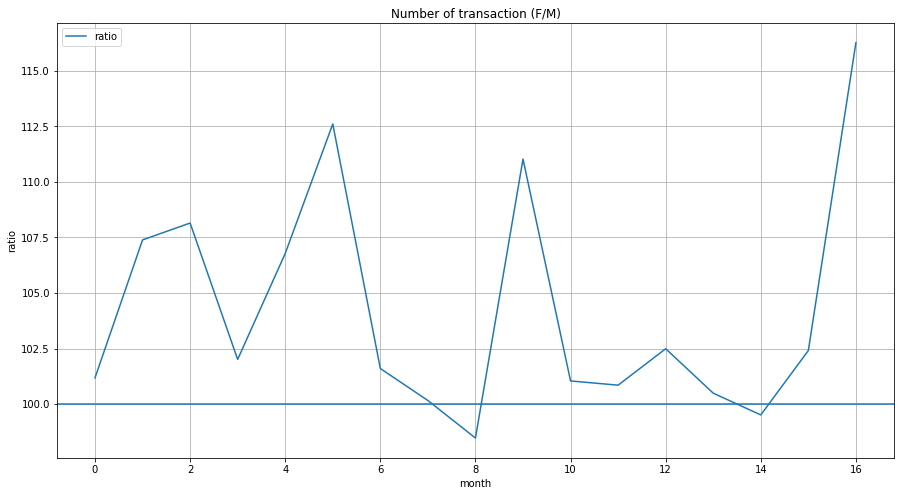

In [295]:
ratio_m = transactions.pivot_table(index = "month",
                                   columns = "target",
                                   values = "client_id",
                                   aggfunc = "count")
ratio_m.columns=["0", "1"]
ratio_m.reset_index(inplace = True)
ratio_m.loc[:, "month"] = ratio_m.loc[:, "month"].astype("int64")
ratio_m.loc[:, "ratio"] = round(ratio_m.loc[:, "0"]/ratio_m.loc[:, "1"]*100, 2)

ax1=ratio_m.plot(x = "month", y = "ratio", title='Number of transaction (F/M)', figsize=(15, 8))
ax1.set_xlabel("month")
ax1.set_ylabel("ratio")
plt.axhline(100)
ax1.grid()

Количество женщин преобладает, но не настолько сильно. То есть, мы можем с уверенностью сказать, что далее, при обучении алгоритма мы будем иметь дело с равномерно распределенными данными, без скошенностей и пр., что стоило бы учесть.

## Выбор алгоритма и обучение
И так, теперь, когда мы вплотную подобрались к самой сути настоящей работы, нам необходимо выбрать тот самый алгоритм, который лучше всего подойдет к выполнению задания - обучение модели, которая способна предиктить целевой признак - **пол** наших пользователей. <br>Наш курс:<br>
1) Определить корреляционные характеристики каждого признака и узнать, какие именно веса у каждого признака, и имеются ли признаки, которые отрицательно / благоприятно будут действовать на модель. Для этих целей мы используем корреляционную матрицу;<br>
2) На оснований весов по таргету выбрать наиболее благоприятный алгоритм;<br>
3) Определиться с метриками качества нашей модели и настроить функцию;<br>
4) Обучить модели;<br>
5) Выдать метрики.

In [254]:
transactions.head(3)

,client_id,in,target,event_name,transaction_purpose,num_days,day_time,month,out
0,880096372458,0.00,0,d7a84628c025d30f7b2c52c958767e76,e3b80d30a727c738f3cff0941f6bc55a,421,0,15.0,561478.94
1,880096372458,224591.58,0,281715cafa675bf359ebaa42cb44fa17,e3b80d30a727c738f3cff0941f6bc55a,270,0,9.0,0.00
2,880096372458,0.00,0,ca43108ded5aabc7793d3f9b928cdd54,926ec030f29f83ce5318754fdb631a33,97,0,4.0,11229.58


In [255]:
#get object cols only and apply LabelEncoder
train[["type", "code"]] = train[["type", "code"]].apply(LabelEncoder().fit_transform)

### CM (corr())
Здесь, вызовем метод corr() - узнаем, какие у нас веса и имеется ли мультиколлинеарность.

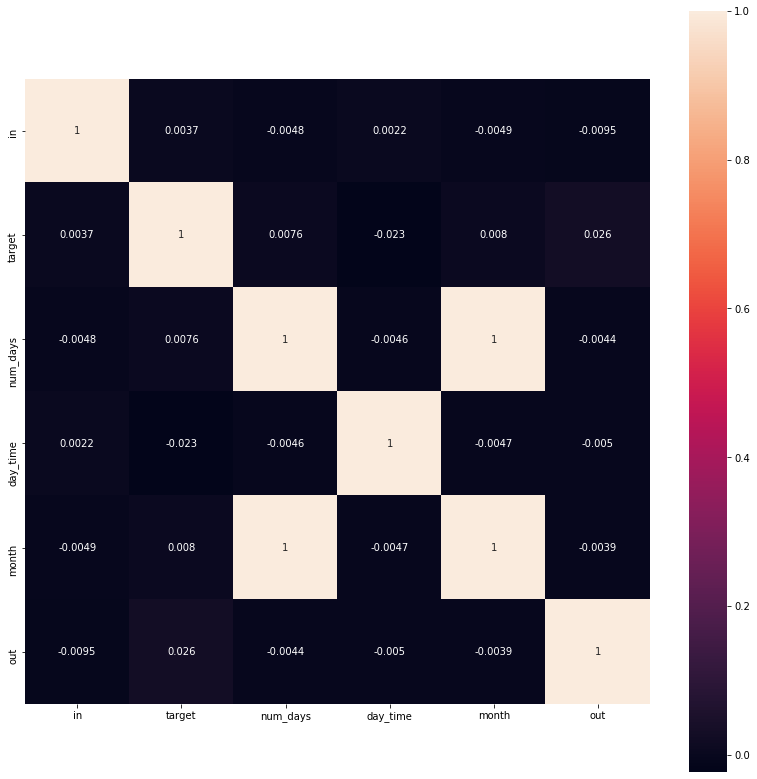

In [277]:
trans_cm = transactions.drop(["client_id"], axis = 1).corr()
a4_dims = (14, 14)

fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(trans_cm, annot = True, square = True)
plt.show()

**Выводы:**
1. В целом, веса всех почти признаков довольно низкие, следовательно здесь единственно возможные варианты алгоритмов классификации для обучения это SVM и Boosting, иные наврядли смогут дать результат лучше подброшенной монеты;
2. И нам вероятно следует избавиться от одной ищ признаков **num_days** и **month**;

### Сплит 

In [257]:
X = train.drop(["client_id"], axis=1)
y = train.loc[:, "target"]

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

### Метрики качества
Естественно, что наличие обученной модели - это полдела. Нам важно также знать, какой результат выдает модель, дабы исключить вероятность GIGO.

In [264]:
def metrics(y_true,y_pred, title = 'Model metrics'):
    display(title)
    display('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    display('Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    display('Recall: {:.2f}'.format(recall_score(y_true, y_pred)))

### XGBClassifier
#### Обучение
Почему именно классфикатор XGB - озвучено выше. Главной метрикой для бинарного классфикатора ялвяется **ROC AUC**. Для начала испытаем каждый из выбранных по-отдельности и узнаем как именно ведет себя эта метрика.

In [260]:
# модель
model = XGBClassifier(
    max_depth = 10,
    eta = 0.1,
    gamma = 0,
    min_child_weight = 0.9,
    reg_lambda = 0,
    alpha = 0.9,
    nrounds = 150,
    subsample = 1)
# кроссвалидация
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
# получим метрику ROC AUC
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
# print metric - ROC AUC
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 1.00000


**Святые силы, ROC AUC=1!!!** И так, теперь, оценим, каким именно образом может себя вести другие метрики. 

#### Валидация

In [265]:
model.fit(X_train, y_train)
# pred and prob;

xgbc_pred = model.predict(X_test)
xgbc_pred

metrics(y_test, xgbc_pred)

'Model metrics'

'Accuracy: 1.00'

'Precision: 1.00'

'Recall: 1.00'

In [268]:
test_y = y_test.to_list()
len(test_y)

18366

In [267]:
compare = pd.DataFrame({'actual':test_y, 'predicted':xgbc_pred})
compare[compare["actual"]==compare["predicted"]]

,actual,predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
18361,0,0
18362,1,1
18363,1,1
18364,1,1


Вуаля! Шалость, как сказал один герой, удалась! Теперь, напоследок, изучим самую модель. Самое время вызвать матрицу Confusion matrix и выявить, где наша модель "споткнулась".
#### Confusion matrix

Text(91.68, 0.5, 'Predicted Label')

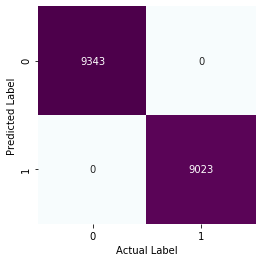

In [276]:
cm = confusion_matrix(compare["actual"], compare["predicted"])
sns.heatmap(cm.T,
            square=True,
            annot=True,
            fmt='d',
            cbar=False,
            cmap="BuPu")
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')

## Вывод
1. Мы выбрали алгоритм на основе XGBClassifier, так как при изучении матрицы корреляции было очевидно, что признаки не давют существенного веса для дальнейшего использования в качестве предикторов;
2. Обучение прошло успешно, так как результаты по метрикам очень и очень высокие и уюедительные. 